In [4]:
#import modules
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import sys
from geopy import distance
from shapely.geometry import Point
import geopandas
import geocoder
from tqdm import tqdm
import random
import os
%matplotlib inline

In [5]:
os.chdir('..')

In [2]:
tqdm.pandas()

In [58]:
# import data
# df_raw = pd.read_csv('RAW_DATA/SF-Housing-Sales.csv')
df_clean = pd.read_csv('ENG_DATA/12-1_Clean_df.csv',index_col=[0])

In [59]:
df_clean['lot_acres'] = df_clean['lot_acres'].fillna((df_clean['lot_acres'].mean()))
df_clean['zoning'] = df_clean['zoning'].fillna('OTHR')

In [60]:
# Add back sf and sf_plot to clean data
df_clean["sf"] = df_raw["sf"]
df_clean["lot_sf"] = df_raw["lot_sf"]

In [61]:
df_clean = df_clean.drop(['roi', 'geometry', 'name', 'num_incidents'], 1)

In [62]:
# Add year on-market, month on-market and year sold, month sold
def computeDateFunc(date, month_not_year): 
    date_format = "%m/%d/%y"
    a = datetime.strptime(date, date_format)
    if month_not_year: 
        return a.month
    else:
        return a.year

In [63]:
df_clean["on_market_year"] = df_clean["on_market_date"].apply(lambda x: computeDateFunc(x, False))
df_clean["on_market_month"] = df_clean["on_market_date"].apply(lambda x: computeDateFunc(x, True))
df_clean["sale_year"] = df_clean["sale_date"].apply(lambda x: computeDateFunc(x, False))
df_clean["sale_month"] = df_clean["sale_date"].apply(lambda x: computeDateFunc(x, True))

In [64]:
df_clean['sf'] = df_clean['sf'].fillna((df_clean['sf'].mean()))
df_clean['lot_sf'] = df_clean['lot_sf'].fillna((df_clean['lot_sf'].mean()))

In [65]:
df_clean.isna().sum()

longitude          0
latitude           0
elevation          0
full_address       0
city               0
street_name        0
zip                0
area               0
district_no        0
subdist_no         0
on_market_date     0
cdom               0
orig_list_price    0
sale_date          0
sale_price         0
rooms              0
baths              0
beds               0
lot_acres          0
year_built         0
zoning             0
drive_side         0
parking            0
park_leased        0
num_parking        0
shopping           0
transportation     0
type               0
views              0
days_on_market     0
sf                 0
lot_sf             0
on_market_year     0
on_market_month    0
sale_year          0
sale_month         0
dtype: int64

In [82]:
#Fix a bug
df_clean.loc[df_clean['longitude'] > -122, 'longitude'] = -122.40995 
df_clean.loc[df_clean['latitude'] < 37.6, 'latitude'] = 37.751602 

In [83]:
df_clean.loc[df_clean['latitude'] < 28]

,longitude,latitude,elevation,full_address,city,street_name,zip,area,district_no,subdist_no,...,type,views,days_on_market,sf,lot_sf,on_market_year,on_market_month,sale_year,sale_month,geometry


In [84]:
df_clean["longitude"].describe()

count    23717.000000
mean      -122.447344
std          0.031135
min       -122.509650
25%       -122.469860
50%       -122.445190
75%       -122.425930
max       -122.370895
Name: longitude, dtype: float64

In [85]:
# data mapping 
df_clean['geometry'] = df_clean.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
geo_clean = geopandas.GeoDataFrame(df_clean, geometry='geometry')
geo_clean.crs = {'init': 'epsg:4326'}

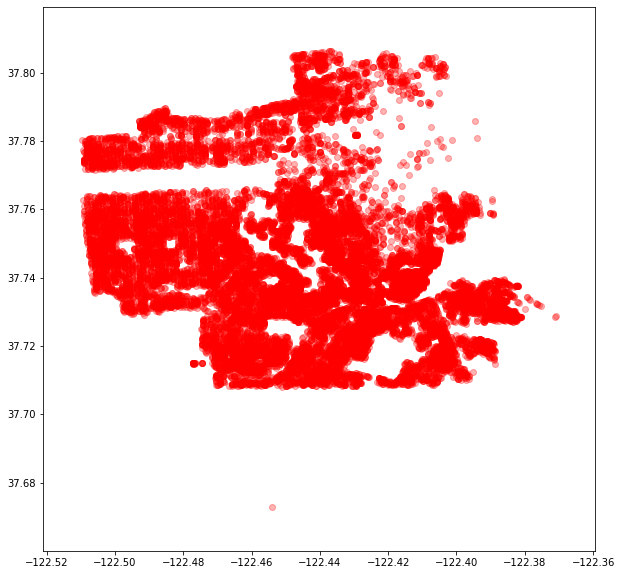

In [86]:
geo_clean.plot(figsize=(13,10), marker="o", color="red", alpha=0.3)

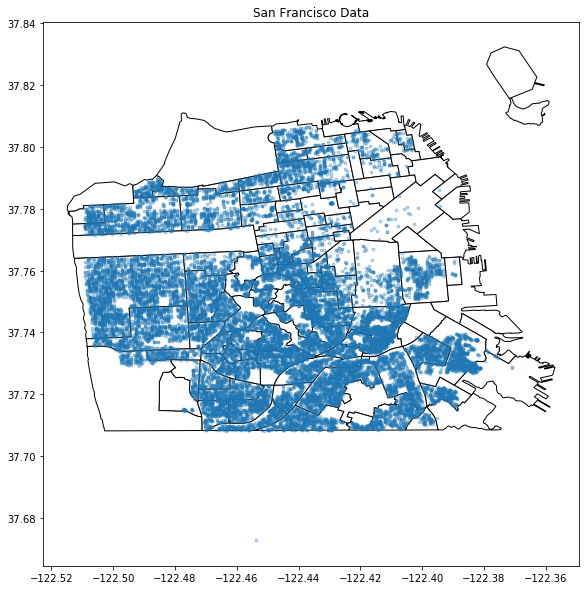

In [87]:
# fig, ax = plt.subplots(1, figsize=(13,10))
fig, ax = plt.subplots(1, figsize=(13,10))
sf_map = sf.plot(ax=ax, color='white', edgecolor='black')
geo_clean.plot(ax=sf_map, marker="o", markersize=8, alpha=0.3)
ax.set_title("San Francisco Data")
plt.show()

In [6]:
#import 20% of crime data 
p = 0.2
df_crime = pd.read_csv(
         'RAW_DATA/Crime.csv',
         header=0, 
         skiprows=lambda i: i>0 and random.random() > p
)
df_crime = df_crime.drop('Location', 1)

In [7]:
#Fix a bug
df_crime.loc[df_crime['X']==-120.5, 'X'] = -122.4237179 
df_crime.loc[df_crime['Y']==90.0, 'Y'] = 37.770497

In [37]:
 # Crime mapping
df_crime['geometry'] = df_crime.apply(lambda row: Point(row['X'], row['Y']), axis=1)

In [38]:
geo_crime = geopandas.GeoDataFrame(df_crime, geometry='geometry')
geo_crime.crs = {'init': 'epsg:4326'}

In [39]:
# add crime data per zip code
sf = geopandas.read_file('RAW_DATA/sf.geojson')
sf.crs = {'init': 'epsg:4326'}
sf = sf.rename(columns={'geometry': 'geometry','nhood':'neighborhood_name'}).set_geometry('geometry')

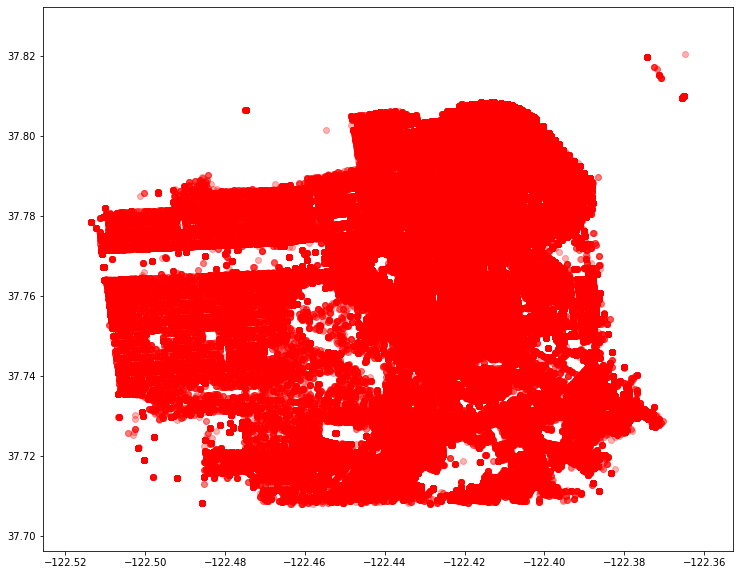

In [40]:
geo_crime.plot(figsize=(13,10), marker="o", color="red", alpha=0.3)

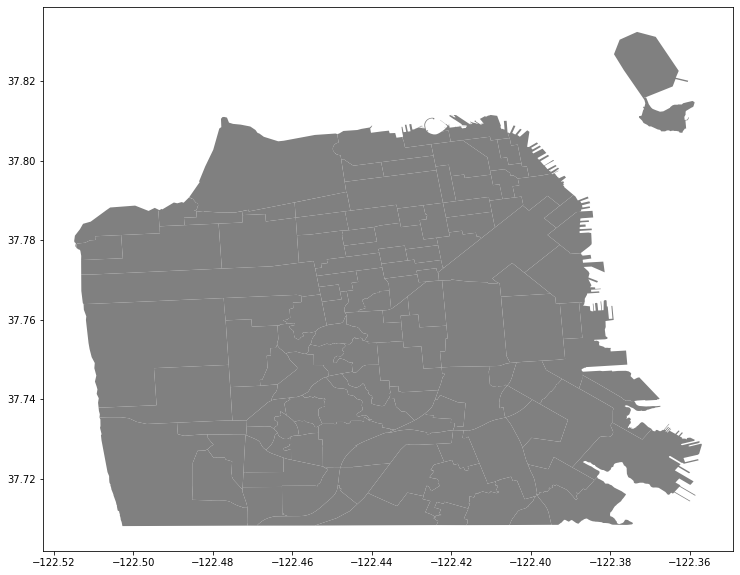

In [42]:
sf.plot(figsize=(13,10), color='gray')
plt.show()

In [1]:
# fig, ax = plt.subplots(1, figsize=(13,10))
fig, ax = plt.subplots(1, figsize=(13,10))
sf_map = sf.plot(ax=ax, color='white', edgecolor='black')
geo_crime.plot(ax=sf_map, marker="o", markersize=8, alpha=0.3)
ax.set_title("San Francisco Incidents of Crime")
plt.show()

NameError: name 'plt' is not defined

In [15]:
# Spatial join
combined = geopandas.tools.sjoin(geo_crime, sf, how='left')
combined.sample(5)

,IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,PdId,geometry,index_right,link,name
128583,146226730,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Monday,10/27/2014,21:00,TARAVAL,NONE,19TH AV / SARGENT ST,-122.471571,37.716127,14622673006244,POINT (-122.47157 37.71613),64.0,http://en.wikipedia.org/wiki/Neighborhoods_in_...,Merced Heights
175586,76036792,LARCENY/THEFT,GRAND THEFT OF PROPERTY,Wednesday,05/23/2007,22:00,NORTHERN,NONE,MARKET ST / CHURCH ST,-122.428950,37.767503,7603679206374,POINT (-122.42895 37.76750),36.0,None,Mission Dolores
144920,150648978,FRAUD,"CREDIT CARD, THEFT OF",Saturday,07/25/2015,23:42,RICHMOND,"ARREST, BOOKED",ANZA ST / 7TH AV,-122.465212,37.779040,15064897809310,POINT (-122.46521 37.77904),4.0,http://www.sfgate.com/neighborhoods/sf/innerri...,Inner Richmond
85308,160666829,ROBBERY,"ROBBERY ON THE STREET, STRONGARM",Thursday,08/18/2016,08:41,BAYVIEW,NONE,1500 Block of REVERE AV,-122.389206,37.731189,16066682903014,POINT (-122.38921 37.73119),85.0,http://en.wikipedia.org/wiki/Neighborhoods_in_...,Bayview
98765,186045465,LARCENY/THEFT,GRAND THEFT OF PROPERTY,Thursday,02/22/2018,14:00,RICHMOND,NONE,700 Block of ARGUELLO BL,-122.458472,37.776705,18604546506374,POINT (-122.45847 37.77671),11.0,"http://en.wikipedia.org/wiki/Lone_Mountain,_Sa...",Lone Mountain


In [40]:
neighborhood_counts = combined.groupby('name')['IncidntNum'].count().reset_index()
neighborhood_counts.columns = ['name','num_incidents']
neighborhood_counts = neighborhood_counts.sort_values(by='num_incidents', ascending=False)

In [44]:
neighborhood_counts

,name,num_incidents
98,South of Market,29563
64,Mission,18785
106,Tenderloin,18730
25,Downtown / Union Square,7912
6,Bayview,6258
...,...,...
68,Monterey Heights,59
114,Westwood Highlands,44
107,Treasure Island,21
51,Lincoln Park / Ft. Miley,19


In [13]:
chloropleth_data = neighborhood_counts.merge(sf)
chloropleth_data = geopandas.GeoDataFrame(chloropleth_data, geometry='geometry')
chloropleth_data.crs = {'init': 'epsg:4326'}

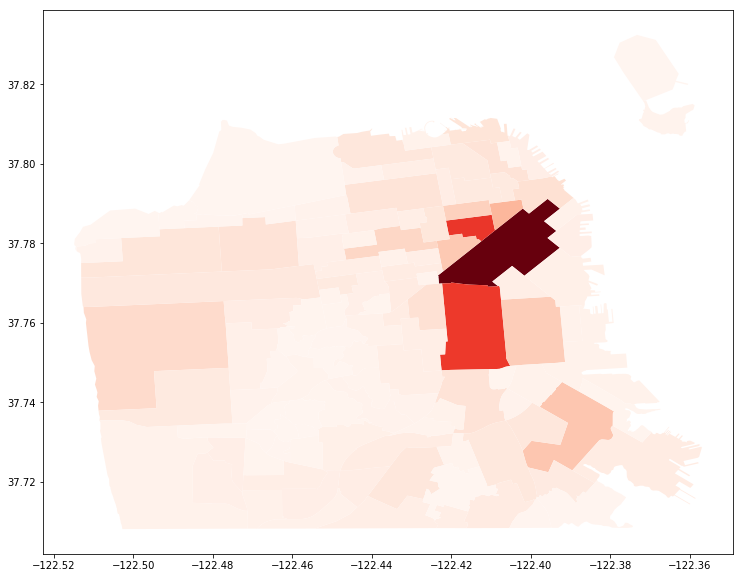

In [21]:
chloropleth_data.plot(column='num_incidents', cmap='Reds', figsize=(13,10))

In [ ]:
#spatial join between aggregated crime data and house location data 

In [32]:
# Crime mapping
df_clean['geometry'] = df_clean.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
geo_clean = geopandas.GeoDataFrame(df_clean, geometry='geometry')
geo_clean.crs = {'init': 'epsg:4326'}

In [33]:
combined2 = geopandas.tools.sjoin(geo_clean, sf, how='left')

In [37]:
combined2 = combined2.drop(columns = ["link", "index_right"], index=1)

In [47]:
df_clean_crime = combined2.merge(neighborhood_counts, how = 'left', on = 'name')

In [51]:
df_clean_crime.to_csv('ENG_DATA/12-1_Clean_df.csv')

In [ ]:
### Source: http://mattmurray.net/unlocking-the-power-of-geospatial-data-with-geopandas/